In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from IPython.display import Image
from sklearn.mixture import GaussianMixture
from scipy.special import logsumexp
import itertools

import warnings; warnings.simplefilter('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Cleaning

In [3]:
UcolNames = ['User_ID', 'Age', 'Sex', 'Occupation', 'ZIP_Code']
Users = pd.read_csv('/content/drive/MyDrive/MLdata/100K/u.user',sep='|', names=UcolNames,encoding='latin-1')

RcolNames = ['User_ID', 'Movie_ID', 'Rating', 'Timestamp']
Ratings = pd.read_csv('/content/drive/MyDrive/MLdata/100K/u.data',sep='\t', names=RcolNames,encoding='latin-1')


In [4]:
Users.shape

(943, 5)

In [5]:
Users.head()

,User_ID,Age,Sex,Occupation,ZIP_Code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [6]:
Ratings.shape

(100000, 4)

In [7]:
Ratings.head()

,User_ID,Movie_ID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
len(Ratings['Movie_ID'].unique())

1682

In [9]:
TotUsers = Users['User_ID'].nunique()
TotMovies = Ratings['Movie_ID'].nunique()

In [10]:
print(TotUsers)

943


In [11]:
print(TotMovies)

1682


# Rating Matrix

In [12]:
RatingsMatrix = Ratings.pivot_table(index=['User_ID'],columns=['Movie_ID'],values='Rating').reset_index(drop=True)
print(RatingsMatrix)
RatingsMatrix.shape

Movie_ID  1     2     3     4     5     ...  1678  1679  1680  1681  1682
0          5.0   3.0   4.0   3.0   3.0  ...   NaN   NaN   NaN   NaN   NaN
1          4.0   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN
2          NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN
3          NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN
4          4.0   3.0   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN
..         ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...
938        NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN
939        NaN   NaN   NaN   2.0   NaN  ...   NaN   NaN   NaN   NaN   NaN
940        5.0   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN
941        NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN
942        NaN   5.0   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN

[943 rows x 1682 columns]


(943, 1682)

In [13]:
TotZeros = np.where(RatingsMatrix == 3)
print(TotZeros)

(array([  0,   0,   0, ..., 942, 942, 942]), array([   1,    3,    4, ..., 1187, 1227, 1329]))


In [14]:
RatingsMatrix.fillna(0, inplace = True)
DataMatrix = np.array(RatingsMatrix)

In [15]:
print(DataMatrix)
DataMatrix.shape

[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]


(943, 1682)

# Rating Predictor Function

In [20]:
def RatingPredictor(DataMatrix, NumberOfClusters):
    Gmm = GaussianMixture(n_components=NumberOfClusters, covariance_type='full', 
                            tol=0.001, reg_covar=1e-06, max_iter=50, 
                            n_init=1, init_params='kmeans', weights_init=None, 
                            means_init=None, precisions_init=None, random_state=42, 
                            warm_start=False, verbose=0, verbose_interval=10)
    Gmm.fit(DataMatrix)
    n = DataMatrix.shape[0]
    d = DataMatrix.shape[1]
    K = Gmm.means_.shape[0]
    #Inverse---------------------------------------
    inv = np.zeros((K,d,d))
    for j in range(K):
        inv[j] = np.linalg.inv(Gmm.covariances_[j])
    #Determinant-----------------------------------
    det = np.zeros((K))
    for j in range(K):
        det[j] = np.linalg.det(Gmm.covariances_[j])
    mean = Gmm.means_
    variance = Gmm.covariances_
    weight = np.log(Gmm.weights_)
    calc = np.zeros((n, K))
    ind = np.zeros((n, d))
    soft = calc
    add = np.zeros((n,))
    dim = np.zeros((n,))
    X_pred = ind
    ind = np.where(DataMatrix != 0, 1, 0)            
    dim = np.sum(ind, axis=1)
    for i in range(n):
        for j in range(K):
            res = DataMatrix[i] - mean[j]
            res = np.multiply(res, ind[i])
            #Multivariate Gaussian
            A = (res.T @ inv[j]) @ res
            C = (dim[i]/2)*np.log(2*np.pi) + np.log(det[j] + 1e-16)/2
            B = 2
            calc[i, j] = weight[j] + (-A/B) - C
    add = logsumexp(calc, axis = 1)

    soft = np.exp(np.subtract(np.transpose(calc), add))

    lg = np.sum(add)

    X_calc = np.transpose(soft) @ Gmm.means_

    #If the entry is a "0" in the original matrix, it will be replaced by the 
    # new predicted values in X_calc
    DataMatrixPredGMM = np.where(DataMatrix == 0, X_calc, DataMatrix)

    #Here we round off all the ratings so that they are integers
    for i in range(DataMatrixPredGMM.shape[0]):
        for j in range(DataMatrixPredGMM.shape[1]):
            DataMatrixPredGMM[i, j] = round(DataMatrixPredGMM[i, j])

    #For calculating the RMSE, we use the predicted values "X_calc"
    for i in range(X_calc.shape[0]):
        for j in range(X_calc.shape[1]):
            X_pred[i, j] = round(X_calc[i, j])
    IndMatrix = np.zeros((TotUsers, TotMovies))
    IndMatrix = np.where(DataMatrix != 0, 1, 0)

    x = np.multiply(X_pred, IndMatrix)
    RMSE_SAE = np.sqrt(np.mean((x - DataMatrix)**2))
    print("RMSE of SAE Model is %f." %RMSE_SAE)
    return DataMatrixPredGMM, RMSE_SAE

In [21]:
DataMatrixPredGMM, RMSE_SAE = RatingPredictor(DataMatrix, 2)
print(DataMatrixPredGMM)
print(RMSE_SAE)

RMSE of SAE Model is 0.714766.
[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [3. 5. 1. ... 0. 0. 0.]]
0.7147657346241669


In [18]:
RMSE = np.zeros((31))
for i in range(1, 31):
    print("Number of clusters are:", i)
    DataMatrixPredGMM, RMSE_SAE = RatingPredictor(DataMatrix, i)
    print(DataMatrixPredGMM)
    print(RMSE_SAE)
    print("-------------------------------------------------------------------")
    RMSE[i] = RMSE_SAE
RMSE

Number of clusters are: 1
RMSE of SAE Model is 0.785721.
[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 [2. 5. 0. ... 0. 0. 0.]]
0.7857214951115679
-------------------------------------------------------------------
Number of clusters are: 2
RMSE of SAE Model is 0.714766.
[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [3. 5. 1. ... 0. 0. 0.]]
0.7147657346241669
-------------------------------------------------------------------
Number of clusters are: 3
RMSE of SAE Model is 0.700165.
[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [3. 5. 0. ... 0. 0. 0.]]
0.7001653699570342
-------------------------------------------------------------------
Number of clusters are: 4
RMSE of SAE Model is 0.683798.
[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 

array([0.        , 0.7857215 , 0.71476573, 0.70016537, 0.68379831,
       0.68040474, 0.67541847, 0.66518173, 0.66286884, 0.66229983,
       0.65664451, 0.65576251, 0.65355135, 0.65324355, 0.65311372,
       0.64932882, 0.64998437, 0.6494725 , 0.64732167, 0.64423562,
       0.64327536, 0.64203533, 0.64102801, 0.63749579, 0.63630593,
       0.6350518 , 0.63632723, 0.63563975, 0.63225194, 0.63015889,
       0.62883185])

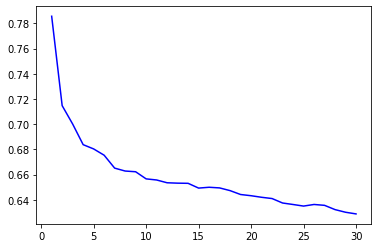

In [19]:
x = np.linspace(1, 30, 30)
plt.plot(x, RMSE[1:], color='blue')